# Molecular Generation Part 1: Data Representation

This project seeks to generate novel molecules using the latest generative models. 

## What is a molecule?

#### mol·e·cule: /ˈmäləˌkyo͞ol/
a group of atoms bonded together, representing the smallest fundamental unit of a chemical compound that can take part in a chemical reaction.

Chemists represent molecules in text using the **SMILES** (Simplified Molecular Input Line Entry System) notation system decveloped in 1987 by David Weininger. <cite data-cite="7333468/UX7ZLAWW"></cite>

In [1]:
smiles = []
with open('../data/01_raw/moses/dataset_v1.csv', 'r') as f:
    _ = f.readline()
    smiles = [f.readline().split(',')[0] for _ in range(120)]
    f.close()

for i in range(10):
    print(smiles[i])

CCCS(=O)c1ccc2[nH]c(=NC(=O)OC)[nH]c2c1
CC(C)(C)C(=O)C(Oc1ccc(Cl)cc1)n1ccnc1
CC1C2CCC(C2)C1CN(CCO)C(=O)c1ccc(Cl)cc1
Cc1c(Cl)cccc1Nc1ncccc1C(=O)OCC(O)CO
Cn1cnc2c1c(=O)n(CC(O)CO)c(=O)n2C
CC1Oc2ccc(Cl)cc2N(CC(O)CO)C1=O
O=C(C1CCCCC1)N1CC(=O)N2CCCc3ccccc3C2C1
CCOC(=O)c1cncn1C1CCCc2ccccc21
COc1ccccc1OC(=O)c1ccccc1OC(C)=O
COc1ccccc1OC(=O)Oc1ccccc1OC


## Cheminformatics

To make our lives easier, we will leverage off the shelf components for the scientific heaevy lifting. [RDKit](http://www.rdkit.org) provides a broad set of tools for the use of computater and informational techniques applied to a range of problems in the field of chemistry.

In [2]:
from rdkit import Chem
from rdkit import RDLogger

import os,sys,inspect
from tqdm import tqdm
sys.path.insert(0,'/home/icarus/app/src')

lg = RDLogger.logger()

lg.setLevel(RDLogger.CRITICAL)

RDKit WARNING: [08:14:21] Enabling RDKit 2019.09.1 jupyter extensions


In [3]:
from rdkit.Chem import Draw
from rdkit.Chem.Draw.MolDrawing import MolDrawing, DrawingOptions
DrawingOptions.bondLineWidth=1.8

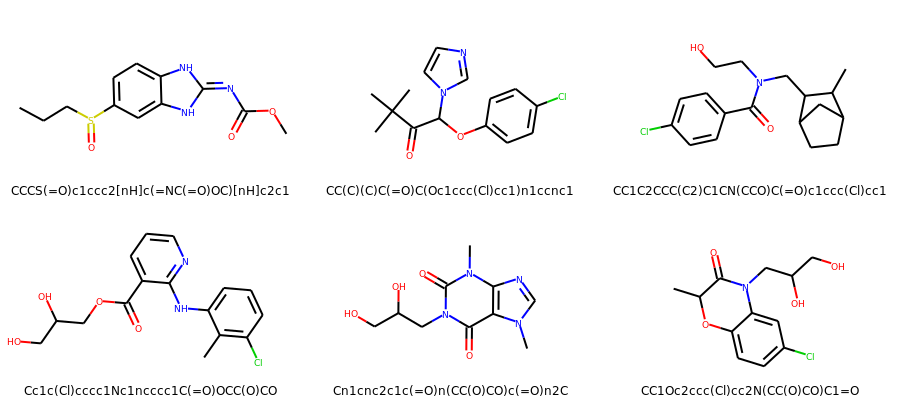

In [4]:
mols = [Chem.MolFromSmiles(smile) for smile in smiles]
Draw.MolsToGridImage(mols[0:6],molsPerRow=3,subImgSize=(300,200),legends=smiles)

## Network Representation

You'll quickly recognize that a molecule is a network of nodes (atoms) attached with edges (bonds). 

We'll leverage the [Deep Graph Library (DGL)](https://github.com/dmlc/dgl) framework and an extrapolation of SMILES data into Junction Trees, as described in Chen, et. al's 2019 ["Junction Tree Variational Autoencoder for Molecular Graph Generation (JTNN)"](https://arxiv.org/abs/1802.04364) paper <cite data-cite="7333468/MY6F98BE"></cite>. The DGL library makes interfacing between PyTorch tensors and network representations easy, while improving computation time by a factor of 2.5X in the case of JTNN.

In [5]:
from structures.moltree import MolTree

In [6]:
mt = MolTree(smiles[0])
mt.recover()
mt.assemble()

import networkx as nx
import matplotlib.pyplot as plt
plt.subplot(121)
nx.draw(mt.to_networkx(), with_labels=True)
plt.show()

<Figure size 640x480 with 1 Axes>

Let's look at how this works.

In [7]:
import dgl
import numpy as np
from dgl import DGLGraph

from utils.chemutils import get_clique_mol, tree_decomp, get_mol, get_smiles, \
                            set_atommap, enum_assemble_nx, decode_stereo

class ElucidateMolTree(DGLGraph):
    def __init__(self, smiles):
        DGLGraph.__init__(self)
        if smiles is None:
            return

        self.nodes_dict = {}
        self.smiles = smiles
        self.mol = get_mol(smiles)

        """Stereo Generation."""
        print("Generating Junction Tree for %s" % str(smiles))
        mol = Chem.MolFromSmiles(smiles)
        print("%s" % str(mol))
        self.smiles2D = Chem.MolToSmiles(mol)
        self.smiles3D = Chem.MolToSmiles(mol, isomericSmiles=True)
        self.stereo_cands = decode_stereo(self.smiles2D)
        print("\t==> %20s: %32s" % (
            "SMILES (2D)", 
            str(self.smiles2D)
        ))
        print("\t==> %20s: %32s" % (
            "SMILES (3D)",
            str(self.smiles3D)
        ))
        print("\t==> %20s:" % (
            "Stereo Candidates"
        ))
        for candidate in self.stereo_cands:
            print("\t%4s%20s| %s" % ('','',str(candidate)))

        """Cliques: [[Neighbor Indices] for Atom in Atoms]"""
        cliques, edges = tree_decomp(self.mol)
        root = 0
        
        for i, clique in enumerate(cliques):
            cmol = get_clique_mol(self.mol, clique)
            csmiles = get_smiles(cmol)
            self.nodes_dict[i] = dict(
                smiles=csmiles,
                mol=get_mol(csmiles),
                clique=clique)
            print("\t\t&>%4s: %12s" % (
                str(i), 
                str(csmiles)
            ))
            if min(clique) == 0:
                root = i

        self.add_nodes(len(cliques))

        if root > 0:
            for attr in self.nodes_dict[0]:
                self.nodes_dict[0][attr] = self.nodes_dict[root][attr]
                self.nodes_dict[root][attr] = self.nodes_dict[0][attr]

        """Generate Edges."""
        src = np.zeros((len(edges) * 2,), dtype='int')
        dst = np.zeros((len(edges) * 2,), dtype='int')
        for  i, (_x, _y) in enumerate(edges):
            x = 0 if _x == root else root if _x == 0 else _x
            y = 0 if _y == root else root if _y == 0 else _y
            src[2*i], dst[2*i] = x, y
            src[2*i+1], dst[2*i+1] = y, x
        
        self.add_edges(src, dst)

        for i in self.nodes_dict:
            self.nodes_dict[i]['nid'] = i+1
            if self.out_degree(i) > 1:
                set_atommap(self.nodes_dict[i]['mol'], self.nodes_dict[i]['nid'])
            self.nodes_dict[i]['is_leaf'] = (self.out_degree(i) == 1)

    @property
    def treesize(self):
        return self.number_of_nodes()
    
    def _recover_node(self, i, original_mol):
        node = self.nodes_dict[i]

        clique = []
        clique.extend(node['clique'])
        if not node['is_leaf']:
            for cidx in node['clique']:
                original_mol.GetAtomWithIdx(cidx).SetAtomMapNum(node['nid'])

        for j in self.successors(i).numpy():
            nei_node = self.nodes_dict[j]
            clique.extend(nei_node['clique'])
            if nei_node['is_leaf']: # Leaf node, no need to mark
                continue
            for cidx in nei_node['clique']:
                # allow singleton node override the atom mapping
                if cidx not in node['clique'] or len(nei_node['clique']) == 1:
                    atom = original_mol.GetAtomWithIdx(cidx)
                    atom.SetAtomMapNum(nei_node['nid'])

        clique = list(set(clique))
        label_mol = get_clique_mol(original_mol, clique)
        node['label'] = Chem.MolToSmiles(Chem.MolFromSmiles(get_smiles(label_mol)))
        node['label_mol'] = get_mol(node['label'])

        for cidx in clique:
            original_mol.GetAtomWithIdx(cidx).SetAtomMapNum(0)

        return node['label']

    def _assemble_node(self, i):
        neighbors = [self.nodes_dict[j] for j in self.successors(i).numpy()
                     if self.nodes_dict[j]['mol'].GetNumAtoms() > 1]
        neighbors = sorted(neighbors, 
                           key=lambda x: x['mol'].GetNumAtoms(), 
                           reverse=True)
        singletons = [self.nodes_dict[j] for j in self.successors(i).numpy()
                      if self.nodes_dict[j]['mol'].GetNumAtoms() == 1]
        neighbors = singletons + neighbors

        cands = enum_assemble_nx(self.nodes_dict[i], neighbors)
        
        if len(cands) > 0:
            self.nodes_dict[i]['cands'], self.nodes_dict[i]['cand_mols'], _ = list(zip(*cands))
            self.nodes_dict[i]['cands'] = list(self.nodes_dict[i]['cands'])
            self.nodes_dict[i]['cand_mols'] = list(self.nodes_dict[i]['cand_mols'])
        else:
            self.nodes_dict[i]['cands'] = []
            self.nodes_dict[i]['cand_mols'] = []

    def recover(self):
        for node in self.nodes_dict:
            self._recover_node(node, self.mol)

    def assemble(self):
        for node in self.nodes_dict:
            self._assemble_node(node)

In [8]:
emt = ElucidateMolTree(smiles[0])

Generating Junction Tree for CCCS(=O)c1ccc2[nH]c(=NC(=O)OC)[nH]c2c1
	==>          SMILES (2D): CCCS(=O)c1ccc2[nH]c(=NC(=O)OC)[nH]c2c1
	==>          SMILES (3D): CCCS(=O)c1ccc2[nH]c(=NC(=O)OC)[nH]c2c1
	==>    Stereo Candidates:
	                        | CCC[S@](=O)c1ccc2[nH]/c(=N\C(=O)OC)[nH]c2c1
	                        | CCC[S@@](=O)c1ccc2[nH]/c(=N\C(=O)OC)[nH]c2c1
	                        | CCC[S@](=O)c1ccc2[nH]/c(=N/C(=O)OC)[nH]c2c1
	                        | CCC[S@@](=O)c1ccc2[nH]/c(=N/C(=O)OC)[nH]c2c1
		&>   0:           CC
		&>   1:           CC
		&>   2:           CS
		&>   3:          O=S
		&>   4:           CS
		&>   5:          C=N
		&>   6:           CN
		&>   7:          C=O
		&>   8:           CO
		&>   9:           CO
		&>  10:  C1=CC=CC=C1
		&>  11:      C1CNCN1
		&>  12:            S
		&>  13:            C


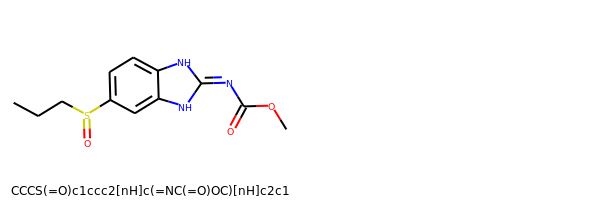

In [9]:
mols = [Chem.MolFromSmiles(smile) for smile in smiles]
Draw.MolsToGridImage(mols[0:1],molsPerRow=2,subImgSize=(300,200),legends=smiles)

## Vocabulary

In [10]:
from structures import Vocab

What Jin, et al. consider a "Vocabulary" is a set of all tractable cluster SMILES.

In [11]:
import concurrent.futures
import os, sys
import threading

MAX_WORKERS = (os.cpu_count()-1)
SAMPLE_SIZE = 1000  # < 1936962

def generate_vocab(smiles, progress=None):
    CHUNK_SIZE=100
    MAX_TREE_WIDTH = sys.maxsize
    SAMPLE_SIZE = 1000  # < 1936962

    cluster_set = set()
    cluster_set_lock = threading.Lock()
    print("Generating vocab from %d smiles" % len(smiles))
    start = 0
    if smiles[0].find('SMILES') >= 0:
        start = 1
        if progress: progress.update(1)
        
    def get_clusters(smiles):
        if type(smiles) == 'str':
            smiles = list(smiles)
        subset = set()
        for smile in smiles:
            mol = MolTree(smile)

            for _, cluster in mol.nodes_dict.items():
                if cluster['mol'].GetNumAtoms() <= MAX_TREE_WIDTH:
                    subset.add(cluster['smiles'])
            
        with cluster_set_lock:
            cluster_set.update(subset)

        if progress: progress.update(CHUNK_SIZE)

    with concurrent.futures.ThreadPoolExecutor(max_workers=MAX_WORKERS) as executor:
        executor.map(get_clusters, 
                     [smiles[start+i*CHUNK_SIZE:start+(i+1)*CHUNK_SIZE] 
                      for i in range((len(smiles[start:])+CHUNK_SIZE-1)//CHUNK_SIZE)])
        
    return cluster_set

with open('../data/01_raw/moses/dataset_v1.csv', 'r') as f:
    _ = f.readline()
    smiles = [f.readline().split(',')[0] for _ in range(SAMPLE_SIZE)]
    with tqdm(total=len(smiles)) as pbar:
        vocab = generate_vocab(smiles, pbar)
    
    print("Size of SMILE dataset: %u" % len(smiles))
    print("Number of unique clusters represented in vocabulary: %u" % len(vocab))

    cluster_table = str()
    for i, cluster in enumerate(vocab):
        format_string = "%20s\n" if i%4==3 else "%19s "
        cluster_table += format_string % cluster 
    print(cluster_table)
    print()
    print("Example slot: {}".format(Vocab(vocab).slots[0]))

  0%|          | 0/1000 [00:00<?, ?it/s]

Generating vocab from 1000 smiles


100%|██████████| 1000/1000 [00:07<00:00, 142.64it/s]

Size of SMILE dataset: 1000
Number of unique clusters represented in vocabulary: 118
           C1=NNCN1             C1CNCN1         C1=CNCCN=C1              C1CCNC1
         C1=CCOC=C1             C1COCN1                  CS             C1=COCC1
         C1=NC=NCC1            C1CCSNC1          C1=CNC=CC1                   CO
          C1=NOC=N1           C1=CCCCC1                 C#N         C1=N[NH]C=N1
                  S                  CF            C1=CNNC1           C1=CNC=NC1
                C=N           C1=NN=CS1                 C#C             C1=COCO1
           C1CCNCC1          C1=CNN=CC1        C1=C[NH]N=C1            C1=NCCCN1
        C1=CC=NC=C1        C1=N[NH]N=N1          C1=CNCCCN1             C1COCCN1
                 NS             C1CCCC1            C1CCOCC1           C1=CCNN=C1
          C1=CCC=C1         C1=NC=NC=N1         C1=CC=CC=C1            C1=NCCCC1
                 CC           C1CCCCCC1          C1=CCCC=C1                    C
           C1CCCCC1     

## Dataloader

We'll inherit PyTorch's Dataset class to build our Dataloader.

In [12]:
from torch.utils.data import Dataset
from dgl.data.utils import download, extract_archive, get_download_dir

_url = "https://media.githubusercontent.com/media/molecularsets/moses/master/data/dataset_v1.csv"

class MOSESDataset(Dataset):
    def __init__(self, vocab=None, training=False):
        self.dir = get_download_dir()
        self.raw_file = '{}/moses_dataset_v1.csv'.format(self.dir)
        download(_url, path=self.raw_file)
        print('Loading MOSES dataset...')
        self.data = None
        with open(self.raw_file) as f:
            self.data = [line.strip('\r\n ').split(',')[0] for line in f]
        if not self.data:
            raise IOException
        
        self.vocab = None
        if vocab:
            self.vocab_file = '{}/{}'.format(self.dir, vocab)
            self.vocab = Vocab([x.strip("\r\n ") for x in open(self.vocab_file)])
        else:
            print('Generating vocab...')
            with tqdm(total=len(self.data)) as pbar:
                vocab = generate_vocab(self.data, pbar)
            with open('../data/03_processed/MOSES/vocab.csv'.format(self.dir), 'w+') as f:
                for cluster in vocab:#tqdm(vocab):
                    f.write('%s\n' % cluster)
            self.vocab = Vocab(vocab)
            
        self.training = training

moses = MOSESDataset('jtnn/vocab.txt')

Loading MOSES dataset...


## References

<div class="cite2c-biblio"></div>

## References

<div class="cite2c-biblio"></div>